ELEC-E5550 - Statistical Natural Language Processing
# SET 3: Vector Space Models

## Released: 09.02.2021
## Deadline: 20.02.2021 at 23:59

# Overview

In this assignment, we're going to represent documents as points in some high-dimensional vector space. We will try to model their semantics so that similar documents would be close in that space. We're going to work with the song lyrics of three artists. More precisely, our goal is to build a system that can suggest what artist could have written a song when presented with the lyrics of a new, previously unseen, song (with a query). We're going to use several approaches to representing songs (several Vector Space Models):
1. songs as sparse vectors of lemma counts
2. songs as sparse vectors weighted by tf-idf
3. songs as sparse vectors weighted by PPMI
4. songs as dense vectors derived from sparse vectors of lemma counts
5. songs as dense vectors derived from sparse vectors weighted by tf-idf
6. songs as dense vectors derived from sparse vectors weighted by PPMI

Hopefully, your models will be able to tell the artists apart! We will evaluate the models by looking at what songs are the closest to a new song in these vector spaces. The perfect system should find only the songs by the same artist. Don't worry if some of the terms above sound confusing, they are all going to be explained below. 

Every song will be represented as a vector of values related to word frequencies in this song. The simple intuition behind the method is that word frequencies in a song capture what a corresponding document is about, its meaning. This approach is count-based. Vector spaces are typically constructed from some kind of co-occurrence matrix. We will be using a term-document matrix in this assignment.

In general, the creation of count-based vector models consists of the following steps:
1. Linguistic processing of text.
2. Frequency matrix building.
3. Mathematical processing of the matrix elements.
4. Dimensionality reduction
5. Evaluation

We're going to use song lyrics of three artists working in different music genres: **Pulp** (britpop, indie pop), **Princess Nokia** (rap), **At the Drive-In** (post-hardcore, emo).

Albums for training:

* Pulp: Different Class, His'n'Hers, We Love Life
* Princess Nokia: Metallic butterfly, Everything sucks, Everything is beautiful
* At the Drive-In: Acrobatic Tenement, Relationship of Command, Vaya


Albums for testing:

* Pulp: This Is Hardcore
* Princess Nokia: 1992
* At the Drive-In: In/Casino/Out

# Table of contents

* [Task 1: Text pre-processing](#task_1)
    * [Step 1.1: Tokenization and normalization](#subtask_1_1)
* [Task 2: Term-document matrix creation](#task_2)
    * [Step 2.1: Create a term-document matrix](#subtask_2_1)
* [Task 3: Mathematical processing of matrix elements](#task_3)
    * [Step 3.1: tf-idf](#subtask_3_1)
    * [Step 3.2: PPMI](#subtask_3_2)
* [Task 4: Place queries into the right vector space](#task_4)
    * [Step 4.1: Term-document matrix for queries](#subtask_4_1)
* [Task 5: Quality evaluation](#task_5)    
    * [Step 5.1: Find N closest documents to a quesry song](#subtask_5_1)
    * [Step 5.2: Compare models](#subtask_5_2)
        * [Step 5.2.1: Count Negatives and Positives](#subsubtask_5_2_1)
        * [Step 5.2.2: Compute the metrics](#subsubtask_5_2_2)
    * [Step 5.3: Choose the best model](#subtask_7_2)
* [Checklist before submission](#checklist)

## TASK 1 <a class="anchor" id="task_1"></a>
## Text pre-processing
## 1.1 <a class="anchor" id="subtask_1_1"></a>
### Tokenization and normalization (1 point)

As you already know, we always start by preparing text data to fit our needs. The first step of our process will be **tokenization** (as usual). The second step will be **normalization**. Normalization helps reduce superficially different strings to one spelling. For example, strings that differ in their capitalization: "Run" and "run", or the strings that differ in their grammatical form: "cat" and "cats". these different strings of characters often convey essentially identical meanings, so it makes sense to unify them into one string in order to get the full distributional statistics. The most common types of normalization for document representations are **lowercasing**, **stemming** and **lemmatization**.

**Stemmers** remove morphological affixes from words, leaving only the word stem. For example, words "jumping", “jumped”, and “jumper” will be reduced to the stem "jump". Stemming is just an approximation of a proper morphological analysis and uses a set of rules of thumb, so for forms like "fly", "flies", "flying" it will assign "fli" and it's not a proper English word. Stemming works well for languages like English, but might not be optimal for morphologically-rich languages like Finnish. **Lemmatizers** assign a group of word forms their lemma (dictionary form), so in the case of "fly"/"flies"/"flying" we get "fly", they are doing proper morphological analysis.

In this assignment, we're going to use [Stanza](https://stanfordnlp.github.io/stanza/index.html) for tokenization and lemmatization.

Create a function in a cell below. It should take the name of the text document:
1. read it
2. tokenize and lemmatize it
3. lowercase lemmas
4. remove lemmas that are present in a stop word list


HINT1: look [here](https://github.com/stanfordnlp/stanza/blob/master/demo/Stanza_Beginners_Guide.ipynb) for Stanza tutorial

HINT2: lowercase only after lemmatization, case affects lemmatization result

In [58]:
!pip install stanza
import stanza
print("Downloading English model...")
stanza.download('en', verbose=False)


def tokenize_and_normalize(file_name, stopwords):
    """Tokenizes, lemmatizes, lowercases and removes stop words.
    
    this function takes in a path to a song, reads the song file,
    tokenizes it into words, then lemmatizes and lowercases these words.
    finally, stopwords given to the function are removed from the list of song lemmas
    
    Parameters
    ----------
    file_name : str
        a path to a text file
    stopwords : list of strings
        stopwords that should be removed
    
    Returns
    -------
    normalized_song : list of strings
        a song represented as a list of its lemmas
    """
    normalized_song=[]
    fp=open(file_name,'r')
    text=fp.read()
    fp.close()
    nlp = stanza.Pipeline(lang='en', processors='tokenize, lemma',  verbose=False)
    nlp_doc=nlp(text)

    for i, sent in enumerate(nlp_doc.sentences):
        for word in sent.words:
            lem=word.lemma
            lem=lem.lower()
            normalized_song.append(lem)

    for lem in stopwords:
        while lem in normalized_song:
            normalized_song.remove(lem)
    
    
    print(normalized_song)
    print(stopwords)
    return normalized_song

In [59]:
from numpy.testing import assert_array_equal
from nose.tools import assert_equal


# CHECKING THE GENERAL PROPERTIES OF THE OUTPUT
dummy_song_path = "/coursedata/03-vsms/dummy_song.txt"
dummy_stop_words = ['lalala', '.']

# check that the output of the function is a list
assert_equal(type(tokenize_and_normalize(dummy_song_path,dummy_stop_words)), list)
# check that it's a list of strings
assert_equal(type(tokenize_and_normalize(dummy_song_path,dummy_stop_words)[0]), str)

# CHECKING THAT THE FUNCTION IS WORKING AS IT SHOULD
correct_normalized_dummy_song = ['this','be','my','awesome','song',
                                 'i','sing','everywhere','i','go',',',
                                 'lalada',',','dalala',',','yep','yep','!','ohhhhh','ohhhhhh','yeaaahhhhh',
                                 'and','i','have','parted','with','my','sanity','!']
assert_equal(tokenize_and_normalize(dummy_song_path,dummy_stop_words), correct_normalized_dummy_song)

# SANITY CHECK FOR THE SONG DATA
song1 = '/coursedata/03-vsms/songs_train/at_the_drive_in_vaya/6_300_mhz.txt'
assert_equal(len(tokenize_and_normalize(song1, dummy_stop_words)), 174)
assert(all([l.lower() for l in tokenize_and_normalize(song1, dummy_stop_words)]))


['this', 'be', 'my', 'awesome', 'song', 'i', 'sing', 'everywhere', 'i', 'go', ',', 'lalada', ',', 'dalala', ',', 'yep', 'yep', '!', 'ohhhhh', 'ohhhhhh', 'yeaaahhhhh', 'and', 'i', 'have', 'parted', 'with', 'my', 'sanity', '!']
['lalala', '.']
['this', 'be', 'my', 'awesome', 'song', 'i', 'sing', 'everywhere', 'i', 'go', ',', 'lalada', ',', 'dalala', ',', 'yep', 'yep', '!', 'ohhhhh', 'ohhhhhh', 'yeaaahhhhh', 'and', 'i', 'have', 'parted', 'with', 'my', 'sanity', '!']
['lalala', '.']
['this', 'be', 'my', 'awesome', 'song', 'i', 'sing', 'everywhere', 'i', 'go', ',', 'lalada', ',', 'dalala', ',', 'yep', 'yep', '!', 'ohhhhh', 'ohhhhhh', 'yeaaahhhhh', 'and', 'i', 'have', 'parted', 'with', 'my', 'sanity', '!']
['lalala', '.']
['in', 'the', 'unlikely', 'event', 'that', 'sarcasm', 'be', 'a', 'unfitting', 'dress', 'amnesia', 'proletariat', ',', 'amnesia', 'proletariat', 'coughing', 'up', 'the', 'coffin', ',', 'cotton', 'candy', 'coat', 'tooth', 'the', 'reflection', 'of', 'you', 'enamel', ',', 'make

### Now we can prepare our songs. 
Run the cell below to get a list of pre-processed songs. We're also going to keep track for each artist of what are the indices of songs in this list.

The songs will be stored in `normalized_songs_train`. The dictionary with indices from this list will be kept in `normalized_songs_index_train`

Note that it's going to take a minute.

In [60]:
import glob
import nltk
import ssl
print("Downloading stop words...")
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download("stopwords", quiet=True)
from nltk.corpus import stopwords

def add_song(song_dict, artist, index):
    """Writes a song index into a dictiionary of artists and their song indices
    
    Parameters
    ----------
    song_dict: dict {artist:list of indices}
        dictionary of artist names with a list of indices of their songs
    artist : str
        artist name - a key to which to add value
    index : int
        value, an index of a song in a list of all songs
    
    Returns
    -------
    song_dict : dict {atrist:lits of song indices}
        song_dict with one new index added
    """
    
    if song_dict[artist] == None:
        song_dict[artist] = [index]
    else:
        song_dict[artist].append(index)   
    return song_dict


# collecting the paths to albums and their songs
train_songs = glob.glob('/coursedata/03-vsms/songs_train/*/*')
# getting stopwords
stop_words_english = stopwords.words('english')

# lets remember indices for each song, we'll need them later
normalized_songs_index_train  = {'pulp':None, 'princess_nokia':None, 'at_the_drive_in':None}
normalized_songs_train = []


for i, song_path in enumerate(train_songs):
    
    normalized_songs_train.append(tokenize_and_normalize(song_path, stop_words_english))
    
    if 'pulp' in song_path:
        normalized_songs_index_train = add_song(normalized_songs_index_train,'pulp', i)
    
    if 'princess_nokia' in song_path:
        normalized_songs_index_train = add_song(normalized_songs_index_train,'princess_nokia',i)
     
    if 'at_the_drive_in' in song_path:
        normalized_songs_index_train = add_song(normalized_songs_index_train,'at_the_drive_in',i)
            
print('There are:', len(normalized_songs_index_train['pulp']), 'songs by Pulp')
print('There are:', len(normalized_songs_index_train['princess_nokia']), 'songs by Princess Nokia')
print('There are:', len(normalized_songs_index_train['at_the_drive_in']), 'songs by At the Drive-In')    

['keep', 'tell', 'voltage', 'hurt', 'little', 'thickness', 'van', 'drop', 'anchor', 'concealing', 'thought', 'hide', 'laugh', 'forever', 'thickness', 'van', 'drop', 'anchor', 'repelling', 'essence', 'swell', ',', 'something', 'blame', 'bleed', 'profusely', ',', 'outside', 'look', 'tame', 'nerve', 'hometown', '...', 'drink', 'slovenly', 'leave', 'alone', 'leave', 'alone', 'brother', 'see', 'five', 'hole', 'flag', 'repelling', 'essence', 'swell', ',', 'something', 'blame', 'hand', 'sweep', 'grenade', 'swim', 'leave', 'alone', 'leave', 'alone', '(', 'brother', '.', ')', 'well', ',', 'brother', 'see', 'five', 'hole', 'flag', 'collect', 'call', 'fuse', 'crawl', 'next', 'hometown', 'collect', 'call', 'fuse', 'crawl', 'feel', 'bite', 'nail', '?', '(', 'feel', '?', 'feel', '?', 'feel', '?', ')', 'feel', 'bite', 'nail', '?', 'leave', 'alone', 'leave', 'alone', 'well', ',', 'brother', 'see', 'five', 'hole', 'flag', 'leave', 'alone', 'leave', 'alone', 'brother', 'see', 'five', 'hole', 'flag', '.'

## TASK 2 <a class="anchor" id="task_2"></a>
## Term-document matrix creation
## 2.1 <a class="anchor" id="subtask_2_1"></a>
### Create a term-document matrix (3 points)
Now that step one (linguistic processing) is complete, we can go on to compute statistics from the documents.

We will be using **term-document matrix**. Formally, in a term-document matrix $X$, each column $x_i$ corresponds to a document $D_i$, each row $x_j$ corresponds to a term $T_j$, and an element $x_{ij}$ is the frequency of a term $T_j$ in a document $D_i$.

Write a function that takes in a list of pre-processed songs and puts their statistics into a term-document matrix. Keep also a list of lemma types corresponding to the rows, we'll need them later.


HINT1: you can use collections.Counter to collect statistics for each song.

HINT2: you can look at the tests, to examine some useful examples of functions performance

In [61]:
import numpy as np
import collections
def create_term_doc_matrix(songs_normalized):
    """ Constructs a frequency term-document matrix
    
    this function takes in a list of songs and returns a term-document matrix
    the rows are lemma types, the columns are songs 
    the rows should be sorted alphabetically
    the order of the columns should be preserved as it's given in songs_normalized
    the cell values are a number of times a lemma was seen in a song
    the value should be zero, if a lemma is absent from a song
    
    Parameters
    ----------
    songs_normalized : a list of lists of strings [['a','a','b'], ['a','b','c']]
        a list of songs represented as a list of lemmas
    
    Returns
    -------
    matrix : numpy array
        a matrix where columns are songs and rows are lemma types,
        the cells of the matrix contain lemma counts in a song,
        the lemmas for rows are sorted alphabetically
        for the example above it will be:
            np.array([[2,1],
                      [1,1],
                      [0,1]])
        
    sorted_vocab : list of strings
        a list of all the lemma types used in all songs (the rows of our matrix)
        the words should be strings sorted alphabetically
        for the example above it should be ['a','b','c']
    """
    
    sorted_vocab=[]
    
    for song in songs_normalized:
        for word in song:
          
            if(word not in sorted_vocab):
                sorted_vocab.append(word)
            
    sorted_vocab.sort()
   
    matrix = np.full((len(sorted_vocab), len(songs_normalized)),0)

    j=0
    for song in songs_normalized:
        coll=collections.Counter(song)
        for word in coll:
            count=coll[word]
            i=sorted_vocab.index(word)
            matrix[i][j]=matrix[i][j]+count
        j=j+1
    

    
    
    # YOUR CODE HERE
    #raise NotImplementedError()
    
    return matrix, sorted_vocab

In [62]:
from numpy.testing import assert_array_equal
from nose.tools import assert_equal


dummy_songs = [['la','la','la','oh',',','woo',"uuuuuh"],
               ['oh', 'la','la','la',"tarara",'tadada', 'blaaa', 'blaaa', '!', '!', '!']]

# CHECKING THE GENERAL PROPERTIES OF THE OUTPUT
# check the shape of the matrix
assert_equal(create_term_doc_matrix(dummy_songs)[0].shape, (9, 2))
# check that the matrix is a numpy ndarray
assert_equal(type(create_term_doc_matrix(dummy_songs)[0]), np.ndarray)
# check that the vocabulary is a list
assert_equal(type(create_term_doc_matrix(dummy_songs)[1]), list)
# check that the vocabulary is a list of strings
assert_equal(type(create_term_doc_matrix(dummy_songs)[1][0]), str)

# CHECKING THAT THE FUNCTION IS WORKING AS IT SHOULD
# check that the vocabulary is sorted properly
assert_equal(create_term_doc_matrix(dummy_songs)[1], ['!', ',', 'blaaa', 'la', 'oh', 'tadada', 'tarara', 'uuuuuh', 'woo'])
# check the count of 'la' in the first song
assert_equal(create_term_doc_matrix(dummy_songs)[0][3][0], 3)
# check that the matrix has the right values in the right places
correct_td_dummy_matrix = np.array([[0., 3.],
                                    [1., 0.],
                                    [0., 2.],
                                    [3., 3.],
                                    [1., 1.],
                                    [0., 1.],
                                    [0., 1.],
                                    [1., 0.],
                                    [1., 0.]])

assert_array_equal(create_term_doc_matrix(dummy_songs)[0], correct_td_dummy_matrix)

# SANITY CHECK FOR THE SONG DATA
# check the shape of the matrix
assert_equal(create_term_doc_matrix(normalized_songs_train)[0].shape, (3214, 99))
# check the first and last lemma
assert_equal(create_term_doc_matrix(normalized_songs_train)[1][0], '!')
assert_equal(create_term_doc_matrix(normalized_songs_train)[1][-1], '’ma')



### Let's make a term-frequency matrix for our songs

Run the cell below to collect the statistics for the songs in our training set.

In [63]:
td_matrix, sorted_vocabulary = create_term_doc_matrix(normalized_songs_train)

## TASK 3 <a class="anchor" id="task_3"></a>
## Mathematical processing of matrix elements

Simple raw frequency counts are not the best at the task of measuring the similarity between documents. The information theory states that the more probable the event, the less information it contains. We've already removed the stop words, but we can go even further. For the VSM models, shared frequent words like "run" or "boy" in two documents are less discriminative for semantics than shared surprising words like "kerning" or "typeface". Thus, it is only logical to give more weight to rare words and take some weight from frequent words. 

To downplay the value of common words some weighting schemes can be applied to a matrix. Two popular approaches are **tf-idf** and **PPMI**. They both are based on the information theory idea that surprising events should carry more weight than expected events.

## 3.1 <a class="anchor" id="subtask_3_1"></a>
### tf-idf (3 points)

The **term frequency–inverse document frequency (tf-idf)** algorithm is a weighting scheme for term-document matrices. It captures the intuition that when a word is frequent in a document but is rare in other documents, it carries a lot of information specific for that particular document, thus it should get more weight. In practice, the **tf-idf** is a combination of two statistics: **term frequency** and **inverse document frequency**. 


**Term frequency** - the number of times a word type $t$ appears in a document $d$

$tf_{t,d} = count(t, d)$


The second statistic of tf-idf is the **inverse document frequency**. It is based on a notion that a less specific term would be used in more documents in a collection than the more specific ones, so the weight of a less specific term should be downplayed. Formally, **idf** is the total number $N$ of documents in a collection, divided by the number of documents $d_{ft}$ containing the term $t$. The fewer documents contain the term, the larger the **idf** becomes. Due to a large number of documents in many collections, $idf$ is usually squashed with a log function. So the resulting term can be obtained in the following way:

**Document frequency** $df_t$ - the number of documents containing $t$

**Inverse document frequency** - the total number $N$ of documents divided by the $df_t$

$idf_t = \log_{10}(\frac{N}{d_{ft}})$

Finally, the *tf-idf* score for a word is just a term frequency multiplied by the inverse document frequency:

$w_{t,d} = tf_{t,d} × id_{ft}$

#### How to weigh a query document with tf-idf?
When you have a new document that you want to compare to the documents in the collection, you need to represent it the same way as your old documents. Suppose, your query document already looks like a vector with the dimensions as the vocabulary of your collection. That is, we disregard any new words that the query document might contain.

The **tf** of this query document **depends only on the query** itself and is computed the same way as for the training documents. 

The **idf** is different. It **depends only on the statistics of the documents in our collection**. That means, we don't add the new document to the statistics, but just use the number we had for the existing collection.
#### task description
Write a function, that takes in a term-document matrix and weights it with the **tf-idf** scheme. To save us time later, our function will both give out a matrix of tf-idf weighted values and a vector of idf values for words in the collection. We will use this vector when representing new documents in the same vector space.

In [64]:
import math
def tf_idf(td_matrix):
    """ Weighs a term-document matrix of raw counts with tf-idf scheme
    
    this function takes in a term-document matrix as a numpy array, 
    and weights the scores with the tf-idf algorithm described above.
    idf values are modified with log_10
    
    Parameters
    ----------
    td_matrix : numpy array 
        a matrix where columns are songs and 
        rows are word counts in a song
    
    Returns
    -------
    tf_idf_matrix : numpy array 
        a matrix where columns are songs and 
        rows are word tf-idf values in a song
        
    idf_vector : numpy array of shape (vocabulary-size, 1)
        a vector of idf values for words in the collection. the shape is (vocabulary-size, 1)
        this vector will be used to weight new query documents
    """
    # YOUR CODE HERE
    sh=td_matrix.shape
    vocabulary_size=sh[0]
    songs_size=sh[1]
    
    print(td_matrix)
    print(vocabulary_size)
    print(songs_size)
    idf_vector=np.full((vocabulary_size,1),0.)
    tf_idf_matrix=np.full((vocabulary_size, songs_size), 0.)
 
    
    print(td_matrix)
    
    for i in range(vocabulary_size):
        nd=0
        for j in range(songs_size):
            if td_matrix[i][j]!=0:
                nd=nd+1
      
        idft=math.log10(songs_size/nd)
        print(idft)
        idf_vector[i][0]=idft
        

        
    for i in range(vocabulary_size):
        for j in range(songs_size):
            tf_idf_matrix[i][j]=td_matrix[i][j]*idf_vector[i][0]
            
    return tf_idf_matrix, idf_vector     


In [65]:
from numpy.testing import assert_array_equal, assert_allclose, assert_almost_equal
from nose.tools import assert_equal


dummy_songs = [['la','la','la','la','oh',',','woo',"uuuuuh"],
               ['oh', 'la','la','la',"tarara",'tadada', 'bla', 'bla', 'bla','bla','bla', '!']]


sorted_dummy_vocab = ['!', ',', 'bla', 'la', 'oh', 'tadada', 'tarara', 'uuuuuh', 'woo']
correct_td_dummy_matrix = np.array([[0., 1.],
                                    [1., 0.],
                                    [0., 5.],
                                    [4., 3.],
                                    [1., 1.],
                                    [0., 1.],
                                    [0., 1.],
                                    [1., 0.],
                                    [1., 0.]])

# CHECKING THE GENERAL PROPERTIES OF THE OUTPUT
# check the shape of the matrix
assert_equal(tf_idf(correct_td_dummy_matrix)[0].shape, (9, 2))
# check the shape of the idf vector
assert_equal(tf_idf(correct_td_dummy_matrix)[1].shape, (9, 1))

# CHECKING THAT THE FUNCTION IS WORKING AS IT SHOULD
# check that the matrix has the right values in the right places
# pay attention to the "la" row: its values are zeros now. make sure you understand why.  

correct_tf_idf_dummy_matrix = np.array([[0.,0.30103],
                                        [0.30103,0.],
                                        [0.,1.50514998],
                                        [0.,0.],
                                        [0.,0.],
                                        [0.,0.30103],
                                        [0.,0.30103],
                                        [0.30103,0.],
                                        [0.30103,0.]])

correct_idf_dummy_vector = np.array([[0.30103],
                                     [0.30103],
                                     [0.30103],
                                     [0.     ],
                                     [0.     ],
                                     [0.30103],
                                     [0.30103],
                                     [0.30103],
                                     [0.30103]])

assert_allclose(tf_idf(correct_td_dummy_matrix)[0], correct_tf_idf_dummy_matrix, rtol=1e-3)
assert_allclose(tf_idf(correct_td_dummy_matrix)[1], correct_idf_dummy_vector, rtol=1e-3)


# SANITY CHECK FOR THE SONG DATA
# check the first value of the idf vector
assert_almost_equal(tf_idf(td_matrix)[1][0][0], 0.8816918422907132, 3)
# check the last value of the idf vector
assert_almost_equal(tf_idf(td_matrix)[1][-1][0], 1.99563519459755, 3)
# check the [0][0] element of the tf-idf matrix
assert_equal(tf_idf(td_matrix)[0][0][3], 0)
# check the [0][3] element of the tf-idf matrix
assert_almost_equal(tf_idf(td_matrix)[0][0][2], 0.8816918422907132, 3)


[[0. 1.]
 [1. 0.]
 [0. 5.]
 [4. 3.]
 [1. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]
9
2
[[0. 1.]
 [1. 0.]
 [0. 5.]
 [4. 3.]
 [1. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]
0.3010299956639812
0.3010299956639812
0.3010299956639812
0.0
0.0
0.3010299956639812
0.3010299956639812
0.3010299956639812
0.3010299956639812
[[0. 1.]
 [1. 0.]
 [0. 5.]
 [4. 3.]
 [1. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]
9
2
[[0. 1.]
 [1. 0.]
 [0. 5.]
 [4. 3.]
 [1. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]
0.3010299956639812
0.3010299956639812
0.3010299956639812
0.0
0.0
0.3010299956639812
0.3010299956639812
0.3010299956639812
0.3010299956639812
[[0. 1.]
 [1. 0.]
 [0. 5.]
 [4. 3.]
 [1. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]
9
2
[[0. 1.]
 [1. 0.]
 [0. 5.]
 [4. 3.]
 [1. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]
0.3010299956639812
0.3010299956639812
0.3010299956639812
0.0
0.0
0.3010299956639812
0.3010299956639812
0.3010299956639812
0.3010299956639812
[[0. 1.]
 [1. 0.]
 [0. 5.]
 [4. 3.]
 [1. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 

## 3.2 <a class="anchor" id="subtask_3_2"></a>
### PPMI (3 points)

An alternative weighting scheme to $tf-idf$ is **Positive Pointwise Mutual Information** (PPMI). When using PPMI scheme, we are asking how more frequently a word occurs in a document than it would have been expected to appear there by chance. The more unexpected this occurrence is, the more weight is given. For example, we might expect words like *run* and *boy* to appear in many documents, but words like *kerning* or *typeface* to appear only in texts about typography.

**PPMI** is a variation of **Pointwise Mutual Information (PMI)**, in which all negative PMI values are replaced with zeros. 

The mutual information compares the probability of observing two events $x$ and $y$ together to the probability of observing $x$ and $y$ independently. Based on this definition of mutual information, PMI between a term $t$ and a document $d$ is defined in the following way:

$PMI_{t,d} = \log_{2}(\frac{P(t,d)}{P(t)P(d)})$

In the case of term-document matrix, the numerator $P(t,d)$ denotes how often a term $t$ was observed in a document $d$, the denominator $P(t)P(d)$ expresses how often we would see a term $t$ in a document $d$ if their probabilities were independent of each other. The larger the numerator, the more weight the pair gets because it means the word occurs in this document more often than by a pure chance.

Let's look at it a bit closer:
- $N$ - total counts of all the words in the collection of documents
- $C_{t,d}$ - count of a term t in a document $d$
- $C_t$ - total count of a term t in the whole document collection (the more we've seen it, the more likely it is to be seen it again)
- $C_d$ - total count of all words in a document $d$ (the length of a document - the more words a document has, the more likely for it to include the word we're interested in)
- $PMI_{t,d} = \log_{2}(\frac{\frac{C_{t,d}}{N}}{\frac{C_t}{N}\frac{C_d}{N}})$

$PPMI_{t,d} = \max(PMI_{t,d},0)$

### How to weigh a query document with PPMI?
We are again in the same situation as with tf-idf: the new document vector should have the same number of elements (dimensions) as a vector in our collection, its dimensions should correspond to the dimension of our collection vectors, and the values should be comparable. To be able to weigh the frequencies in the new documents, we are going to need the $C_t$ statistic and $N$ to come **from the collection**. The $C_{t,d}$ and $C_d$ values would come **from the query vector**.

#### task description

Write a function that can weight with **PPMI** scheme both train and test term-document matrices.

In [66]:
def ppmi(td_matrix, query_matrix = None):
    """Weighs a term-document matrix of raw counts with the PPMI scheme
    
    this function takes in a term-document matrix as a numpy array, 
    and weights the scores with the PPMI scheme described above
    use PMI values are modified with log_2
    if term-document matrix for songs of a test set is given as well,
    the functions returns only PPMI weighted test set (query) matrix
    
    Parameters
    ----------
    td_matrix : numpy array 
        a matrix where columns are collection songs and 
        rows are word counts in a song
    query_matrix : numpy array
        a numpy array where columns are query songs and 
        rows are word counts in a song
    
    Returns
    -------
    ppmi_matrix - a numpy array 
        a matrix where columns are songs and 
        rows are ppmi word values in a song
    """
    sh=td_matrix.shape
    
    songs_size=sh[1]
    vocabulary_size=sh[0]
    ppmi_matrix=np.full((sh[0],sh[1]), 0.)
    
    Ct=np.full((vocabulary_size,1),0.)
    N=0
    Cd=np.full((songs_size,1),0.)
    for i in range(vocabulary_size):
        for j in range(songs_size):
            N=td_matrix[i][j]+N
            Ct[i]=td_matrix[i][j]+Ct[i]
            Cd[j]=td_matrix[i][j]+Cd[j]
    print(td_matrix[i][j])           
    #print(td_matrix[0][1])
    #print(math.log2(td_matrix[0][1]))
    if query_matrix is None:
        for i in range(vocabulary_size):
            for j in range(songs_size):
                ppmi_matrix[i][j]=(td_matrix[i][j]/N)/(Ct[i]*Cd[j]/(N*N))
                if(ppmi_matrix[i][j]!=0):
                    ppmi_matrix[i][j]=max(math.log2(ppmi_matrix[i][j]),0)
                else:
                    ppmi_matrix[i][j]=0
    else:
        sh=query_matrix.shape
        ppmi_matrix=np.full((sh[0],sh[1]), 0.)
        Cd=np.full((sh[1],1),0.)
        for i in range(sh[0]):
            for j in range(sh[1]):
                Cd[j]=query_matrix[i][j]+Cd[j]
        for i in range(sh[0]):
            for j in range(sh[1]):
                ppmi_matrix[i][j]=(query_matrix[i][j]/N)/(Ct[i]*Cd[j]/(N*N))
                if(ppmi_matrix[i][j]!=0):
                    ppmi_matrix[i][j]=max(math.log2(ppmi_matrix[i][j]),0)
                else:
                    ppmi_matrix[i][j]=0
    print(ppmi_matrix)
    return ppmi_matrix

In [67]:
from numpy.testing import assert_array_equal, assert_allclose
from nose.tools import assert_equal
np.seterr(divide = 'ignore')


dummy_songs = [['la','la','la','la','oh',',','woo',"uuuuuh"],
               ['oh', 'la','la','la',"tarara",'tadada', 'bla', 'bla', 'bla','bla','bla', '!']]


sorted_dummy_vocab = ['!', ',', 'bla', 'la', 'oh', 'tadada', 'tarara', 'uuuuuh', 'woo']
correct_td_dummy_matrix = np.array([[0., 1.],
                                    [1., 0.],
                                    [0., 5.],
                                    [4., 3.],
                                    [1., 1.],
                                    [0., 1.],
                                    [0., 1.],
                                    [1., 0.],
                                    [1., 0.]])

td_dummy_query1 = np.array([[0.],
                           [1.],
                           [8.],
                           [1.],
                           [0.],
                           [0.],
                           [1.],
                           [2.],
                           [4.]])



td_dummy_query2 = np.array([[0., 2., 2.],
                           [1., 3., 2.],
                           [8., 4., 2.],
                           [1., 2., 2.],
                           [0., 5., 2.],
                           [0., 0., 2.],
                           [1., 0., 2.],
                           [2., 0., 2.],
                           [4., 0., 2.]])

# CHECKING THE GENERAL PROPERTIES OF THE OUTPUT
# check the shape of the matrix
assert_equal(ppmi(correct_td_dummy_matrix).shape, (9, 2))
assert_equal(ppmi(correct_td_dummy_matrix, td_dummy_query1).shape, (9, 1))
assert_equal(ppmi(correct_td_dummy_matrix, td_dummy_query2).shape, (9, 3))

# CHECKING THAT THE FUNCTION IS WORKING AS IT SHOULD
# check that the matrix has the right values in the right places
# pay attention to the row of "woo" and the row of "tarara" why are the ppmi values different for diiferent documents? 

correct_ppmi_dummy_matrix = np.array([[0.        , 0.73696559],
                                      [1.32192809, 0.        ],
                                      [0.        , 0.73696559],
                                      [0.51457317, 0.        ],
                                      [0.32192809, 0.        ],
                                      [0.        , 0.73696559],
                                      [0.        , 0.73696559],
                                      [1.32192809, 0.        ],
                                      [1.32192809, 0.        ]])

assert_allclose(ppmi(correct_td_dummy_matrix), correct_ppmi_dummy_matrix, rtol=1e-3)

correct_ppmi_dummy_query1 = np.array([[0.        ],
                                     [0.23446525],
                                     [0.91253716],
                                     [0.        ],
                                     [0.        ],
                                     [0.        ],
                                     [0.23446525],
                                     [1.23446525],
                                     [2.23446525]])

correct_ppmi_dummy_query2 = np.array([[0.        , 1.32192809, 1.15200309],
                                   [0.23446525, 1.9068906 , 1.15200309],
                                   [0.91253716, 0.        , 0.        ],
                                   [0.        , 0.        , 0.        ],
                                   [0.        , 1.64385619, 0.15200309],
                                   [0.        , 0.        , 1.15200309],
                                   [0.23446525, 0.        , 1.15200309],
                                   [1.23446525, 0.        , 1.15200309],
                                   [2.23446525, 0.        , 1.15200309]])

assert_allclose(ppmi(correct_td_dummy_matrix, td_dummy_query1), correct_ppmi_dummy_query1, rtol=1e-3)
assert_allclose(ppmi(correct_td_dummy_matrix, td_dummy_query2), correct_ppmi_dummy_query2, rtol=1e-3)


0.0
[[0.         0.73696559]
 [1.32192809 0.        ]
 [0.         0.73696559]
 [0.51457317 0.        ]
 [0.32192809 0.        ]
 [0.         0.73696559]
 [0.         0.73696559]
 [1.32192809 0.        ]
 [1.32192809 0.        ]]
0.0
[[0.        ]
 [0.23446525]
 [0.91253716]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.23446525]
 [1.23446525]
 [2.23446525]]
0.0
[[0.         1.32192809 1.15200309]
 [0.23446525 1.9068906  1.15200309]
 [0.91253716 0.         0.        ]
 [0.         0.         0.        ]
 [0.         1.64385619 0.15200309]
 [0.         0.         1.15200309]
 [0.23446525 0.         1.15200309]
 [1.23446525 0.         1.15200309]
 [2.23446525 0.         1.15200309]]
0.0
[[0.         0.73696559]
 [1.32192809 0.        ]
 [0.         0.73696559]
 [0.51457317 0.        ]
 [0.32192809 0.        ]
 [0.         0.73696559]
 [0.         0.73696559]
 [1.32192809 0.        ]
 [1.32192809 0.        ]]
0.0
[[0.        ]
 [0.23446525]
 [0.91253716]
 [0.        ]
 [0.        ]
 [0.  

### Let's weigh our term-dictionary matrix
Run the cell below to collect the weighted statistics.

In [68]:
# tf-idf
tf_idf_matrix, idf_vector = tf_idf(td_matrix)

# PPMI
ppmi_matrix = ppmi(td_matrix)

[[4 1 1 ... 0 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
3214
99
[[4 1 1 ... 0 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
0.8816918422907132
0.7403626894942439
1.99563519459755
1.1505371545832932
0.23220720103461262
1.99563519459755
1.99563519459755
1.99563519459755
0.10354059190706949
1.99563519459755
0.5806618466267319
0.5806618466267319
0.008863460331305032
0.2796318509627507
1.99563519459755
1.99563519459755
1.99563519459755
1.99563519459755
1.99563519459755
1.99563519459755
1.99563519459755
0.9164539485499251
0.765186273219276
1.99563519459755
1.99563519459755
1.99563519459755
1.99563519459755
1.99563519459755
1.99563519459755
1.99563519459755
1.99563519459755
1.99563519459755
1.99563519459755
1.99563519459755
1.99563519459755
1.99563519459755
1.99563519459755
1.99563519459755
1.99563519459755
1.99563519459755
1.99563519459755
1.99563519459755
1.69460519893

## Dense vectors

Raw counts, tf-idf and PPMI are called **sparse representations**. That means they contain lots of zeros because most of the words never appear in every document.

Sparse frequency matrices work well, but keeping all vector components can be very computationally expensive in some tasks, moreover, such frequency matrices can take up a lot of storage space. But more importantly, sparse vectors dedicate different dimensions for very similar words like *car* and *automobile* with no modeled relationship between the dimensions. It would be useful to model similar words in the same dimension. Such low-dimensional **dense representations**, vectors can be obtained by performing dimensionality reduction on sparse vectors.

### LSI

One of the popular methods to transform a sparse VSM into a dense VSM is based on **Truncated Singular Value Decomposition (SVD)**. **SVD** is a method for ranking the dimensions of a dataset by their "importance". The dimensions along which the data varies the most are considered more important than the dimensions with low variation. Meaning: we want dimensions that can help distingish between different vectors. **Truncated** means keeping only $k$ most important dimensions out of all.

We can approximate our term-document matrix with one of lower rank using the **Truncated SVD**. This approximation matrix yields a new representation for each document in the collection. You can think of it as assigning documents to latent topics starting we topics that help to differenciate between the doicuments the best. We will need to transform our query documents into this low-rank representation as well, enabling us to compute query-document similarity scores in this low-rank representation. This process is known as **Latent Semantic Indexing (LSI)**. 

NOTE: We can view our term-document matrix not only as representation of documents, but also as the representation of words (similar words appear in similar documents). **Truncated SVD** can also be applied to assign words hiddent latent topics. This process is called **Latent Semantic Analysis (LSA)**.

You can read about the details of **LSI** [here](https://www.engr.uvic.ca/~seng474/svd.pdf) or [here](https://nlp.stanford.edu/IR-book/pdf/18lsi.pdf)


### UMAP

**Uniform Manifold Approximation and Projection** or **UMAP** for short is also a dimensionality reduction technique. It is mostly used for visulizing data. **UMAP** tries to map high dimensional data into lower dimension while preserving the distances between the objects. That means documents that were close in the original hight dimensional space would still be close in the lower dimesional space. You can learn the intuition by watching [this video](https://www.youtube.com/watch?v=eN0wFzBA4Sc&ab_channel=StatQuestwithJoshStarmer).

The two main parameters that control the mapping is n_components and n_neighbors. n_components tells the algorithm how many dimensions we want our final vectors to have. You can think about n_neighbors as the number of documents a document would have a similar distance to in lower dimensional approximation. If we put this parameter to 3, we ask the algorithm to focus on preserving the distances to the 2 nearest neighbours of each document. You can read more about the parameters [here](https://umap-learn.readthedocs.io/en/latest/parameters.html).


### Transforming + visualizing

Now, we will assign our documents to their 30 latent topics and visualize what have come of it.

In [69]:
!pip install umap-learn
import umap
from sklearn.decomposition import TruncatedSVD

td_svd=TruncatedSVD(n_components=30)
td_matrix_dense = td_svd.fit_transform(td_matrix.T).T
td_umap = umap.UMAP(n_neighbors=10, n_components=2)
td_matrix_umap = td_umap.fit_transform(td_matrix_dense.T).T

tf_idf_svd=TruncatedSVD(n_components=30)
tf_idf_matrix_dense = tf_idf_svd.fit_transform(td_matrix.T).T
tf_idf_umap = umap.UMAP(n_neighbors=10, n_components=2)
tf_idf_matrix_umap = tf_idf_umap.fit_transform(tf_idf_matrix_dense.T).T

ppmi_svd=TruncatedSVD(n_components=30)
ppmi_matrix_dense = ppmi_svd.fit_transform(td_matrix.T).T
ppmi_umap = umap.UMAP(n_neighbors=10, n_components=2)
ppmi_matrix_umap = ppmi_umap.fit_transform(ppmi_matrix_dense.T).T

### Let's visualize our models! 
When we have 2-D representations of songs, we can actually plot them and see if they make sense. Remember, we want songs by the same artist be close to each other. Can you predict which model out of these 3 will perform better? Which artist would be easier to recognize correctly?

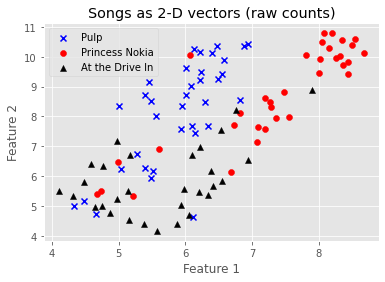

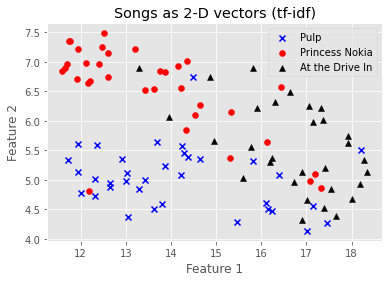

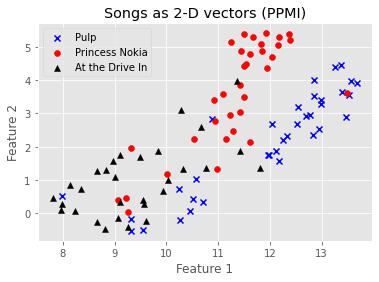

In [70]:
import matplotlib.pyplot as plt

def plot_songs(song_matrix, title, songs_index):
    """ Plots 2d vectors of songs and marks song with an artist label
    
    Parameters
    ----------
    song_matrix : numpy array
        columns are songs
        rows a latent topics
    title : str
        title for the plot
    songs_index : dict
        dictionary of artist and their songs indices in the song_matrix
    indices_to_remove : list
        list of songs to not plot
    """

    plt.style.use('ggplot')
    pulp_indices = songs_index['pulp']
    princess_nokia_indices = songs_index['princess_nokia']
    at_the_drive_in_indices = songs_index['at_the_drive_in']
    
    
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

    pulp = plt.scatter(song_matrix[0,pulp_indices], song_matrix[1,pulp_indices], marker="x", color="blue")
    princess_nokia = plt.scatter(song_matrix[0,princess_nokia_indices], song_matrix[1,princess_nokia_indices], marker="o", color="red")
    at_the_drive_in = plt.scatter(song_matrix[0,at_the_drive_in_indices], song_matrix[1,at_the_drive_in_indices], marker="^", color="black")
    
    plt.legend((pulp, princess_nokia, at_the_drive_in),('Pulp','Princess Nokia','At the Drive In'))
    
    plt.show()
    
plot_songs(td_matrix_umap, "Songs as 2-D vectors (raw counts)", normalized_songs_index_train)
plot_songs(tf_idf_matrix_umap, "Songs as 2-D vectors (tf-idf)", normalized_songs_index_train)
plot_songs(ppmi_matrix_umap, "Songs as 2-D vectors (PPMI)", normalized_songs_index_train)

## TASK 4 <a class="anchor" id="task_4"></a>
## Place queries into the right vector space

Now we have new songs coming into our system and we would like to know what artist they were written by.
The first thing to do is to adjust our query documents to the way we represent the songs in our systems.

1. Raw counts: pre-process, collect counts
2. Tf-idf: pre-process, collect counts, weigh
3. PPMI: pre-process, collect counts, weigh
4. UMAP of Raw counts: pre-process, collect counts, UMAP transform
5. UMAP of Tf-idf: pre-process, collect counts, weigh, UMAP transform
6. UMAP of PPMI: pre-process, collect counts, weigh, UMAP transform

### Step 1: Read and Normalize songs
the first step would be to just collect the lemmas for songs in test set using the same pre-processing pipeline as we were using for the training set. Run the cell below to collect the statistics. Make sure you haven't used the name of the stopword list, to not get different results.

* `normalized_songs_test` - stores the pre-processed song from the test set
* `normalized_songs_index_test` - record which artist the test songs belong to 

In [71]:
# collect the paths to the albums and songs
test_songs = glob.glob('/coursedata/03-vsms/songs_test/*/*')

normalized_songs_index_test  = {'pulp':None, 'princess_nokia':None, 'at_the_drive_in':None}
normalized_songs_test = []

for i, song_path in enumerate(test_songs):
    
    normalized_songs_test.append(tokenize_and_normalize(song_path, stop_words_english))
    
    if 'pulp' in song_path:
        normalized_songs_index_test = add_song(normalized_songs_index_test,'pulp', i)
    
    if 'princess_nokia' in song_path:
        normalized_songs_index_test = add_song(normalized_songs_index_test,'princess_nokia',i)
     
    if 'at_the_drive_in' in song_path:
        normalized_songs_index_test = add_song(normalized_songs_index_test,'at_the_drive_in',i)
        
        
# some tests to see that things are as they should         
assert_equal(len(normalized_songs_test), 34)
assert_equal(len(normalized_songs_index_test['pulp']), 14)
assert_equal(len(normalized_songs_index_test['princess_nokia']), 9)
assert_equal(len(normalized_songs_test[0]), 153)

['say', 'thirteen', "'s", 'number', 'double', 'agent', 'fund', 'secret', 'hive', ',', 'worker', 'life', 'sweet', 'honeycombed', 'hunger', 'ravenous', 'fund', 'incognito', 'razor', 'burn', 'talcum', 'powder', 'fingerprint', 'sweet', 'honeycombed', 'go', 'stick', 'tongue', 'north', 'pole', 'read', 'graffiti', 'splatter', 'convertible', 'bullet', 'x-marked', ',', 'rumor', 'jet', '-', 'lag', 'wink', 'eye', ',', 'stab', 'pitchfork', 'funded', ',', 'fund', ',', 'fund', 'sweet', 'honeycombed', 'funded', ',', 'fund', ',', 'fund', 'sweet', 'honeycombed', 'funded', ',', 'fund', ',', 'fund', 'sweet', 'honeycombed', 'funded', ',', 'fund', ',', 'fund', 'part', 'hair', 'grassy', 'knoll', 'cavity', 'candy', 'havana', 'captivity', 'hear', 'mug', 'shot', ',', 'patsy', 'inclined', 'let', 'pollen', 'make', 'sneeze', 'sweet', 'honeycombed', 'sweet', 'honeycombed', 'sweet', 'honeycombed', 'sweet', 'honeycombed', 'funded', ',', 'fund', ',', 'fund', 'sweet', 'honeycombed', 'funded', ',', 'fund', ',', 'fund',

## 4.1 <a class="anchor" id="#subtask_4_1="></a>
### Step 2: Term-document matrix for queries (3 points)

Well, this part is a bit tricky. There might be new, unseen words in our queries, and if we count them, we just won't be able to compare our new documents to our old documents (different words = different dimensions = different vector spaces). To avoid this problem, we will need to only count the things we've seen in the training corpus. Luckily, we've collected the sorted vocabulary!

Modify the `create_term_doc_matrix()` function, so that it takes a query document, an old sorted vocabulary, and counts only the words that are in our train vocabulary.

In [72]:
def create_term_doc_matrix_queries(normalized_queries, sorted_vocabulary):
    """ Constructs a frequency term-document matrix for queries
    
    this function takes in a list of songs and a vocabulary list and returns a term-document matrix
    the rows are lemma types as given in vocabulary, the columns are songs 
    the rows should be in the same order as in vocabulary given
    the order of the columns should be preserved as it's given in normalized_queries
    the cell values are a number of times a lemma was seen in a song
    the value should be zero, if a lemma is absent from a song
    
    Parameters
    ----------
    normalized_queries : a list of lists of strings [['a','a','b','d'], ['a','b','c']]
        a list of songs represented as a list of lemmas
    sorted_vocabulary : list of strings
        a list of all the lemma types used in all training songs (the rows of our matrix)
        the words are strings sorted alphabetically
        for our example it will be ['a','b','c']
    
    Returns
    -------
    query_matrix : numpy array
        a matrix where columns are songs in normalized_queries 
        and rows are lemma types from sorted_vocabulary.
        for the example above it will be:
            np.array([[2,1],
                      [1,1],
                      [0,1]])
        'd' is not included in the matrix, becaus it is absent from sorted_vocabulary
    """
    sh0=len(sorted_vocabulary)
    sh1=len(normalized_queries)
    query_matrix=np.full((sh0, sh1),0.)
    j=0
    for song in normalized_queries:
        coll=collections.Counter(song)
        for word in coll:
            if(word in sorted_vocabulary):
                i=sorted_vocabulary.index(word)
                count=coll[word]
                query_matrix[i][j]=count
        j=j+1         
    # YOUR CODE HERE
    #raise NotImplementedError()
    
    return query_matrix   

In [73]:
sorted_dummy_vocab = ['!', ',', 'bla', 'la', 'oh', 'tadada', 'tarara', 'uuuuuh', 'woo']
new_dummy_songs = [['la','oh',',','pada',"uuuuuh"],
                   ['toot','toot']]

# CHECKING THE GENERAL PROPERTIES OF THE OUTPUT
# check the shape of the matrix
assert_equal(create_term_doc_matrix_queries(new_dummy_songs, sorted_dummy_vocab).shape, (9, 2))

# CHECKING THAT THE FUNCTION IS WORKING AS IT SHOULD
# check that the matrix has the right values in the right places
correct_td_new_dummy_matrix = np.array([[0., 3.],
                                        [1., 0.],
                                        [0., 2.],
                                        [3., 3.],
                                        [1., 1.],
                                        [0., 1.],
                                        [0., 1.],
                                        [1., 0.],
                                        [1., 0.]])

assert_array_equal(create_term_doc_matrix_queries(new_dummy_songs, sorted_dummy_vocab),np.array([[0., 0.],
                                                                                                [1., 0.],
                                                                                                [0., 0.],
                                                                                                [1., 0.],
                                                                                                [1., 0.],
                                                                                                [0., 0.],
                                                                                                [0., 0.],
                                                                                                [1., 0.],
                                                                                                [0., 0.]]))
# SANITY CHECK FOR SONG DATA
# check the shape
assert_equal(create_term_doc_matrix_queries(normalized_songs_test, sorted_vocabulary).shape, 
       (len(sorted_vocabulary), len(normalized_songs_test)))
# check the X_test[0][0] value
assert_equal(create_term_doc_matrix_queries(normalized_songs_test, sorted_vocabulary)[0][0],0)
# check the X_test[0][-3] value
assert_equal(create_term_doc_matrix_queries(normalized_songs_test, sorted_vocabulary)[0][6],3)


### Step 3: Get tf-idf counts
### Step 4: Get PPMI counts
### Steps 5-8 transform matrices with UMAP
Run the cell below to:
* collect term-document matrix for the test set
* weigh term-document matrix with tf-idf (with the help of `idf_vector` we've computed before)
* weigh term-document matrix with PPMI
* transform three matrices above into dense vector spaces with UMAP (with the help of reducers we've fit in the UMAP step)
* plot dense vectors for songs in the test set. Are different artists separated?

0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


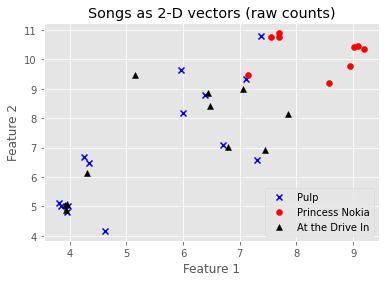

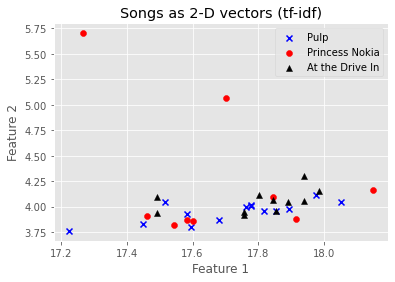

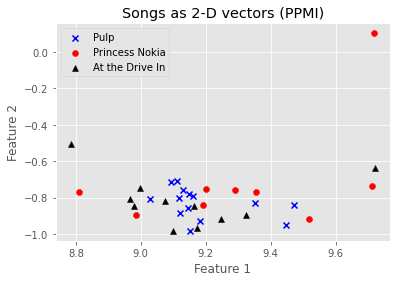

In [74]:
# step 2 collect term-document matrix
td_queries = create_term_doc_matrix_queries(normalized_songs_test, sorted_vocabulary)
# step 3 weigh term-document matrix with tf-idf
tf_idf_queries = td_queries*idf_vector 
# step 4 weigh term-document matrix with PPMI
ppmi_queries = ppmi(td_matrix, td_queries)

# steps 5-8
td_queries_dense = td_svd.transform(td_queries.T).T
td_queries_umap = td_umap.transform(td_queries_dense.T).T
tf_idf_queries_dense = tf_idf_svd.transform(tf_idf_queries.T).T
tf_idf_queries_umap = tf_idf_umap.transform(tf_idf_queries_dense.T).T
ppmi_queries_dense = ppmi_svd.transform(ppmi_queries.T).T
ppmi_queries_umap = ppmi_umap.transform(ppmi_queries_dense.T).T

plot_songs(td_queries_umap, "Songs as 2-D vectors (raw counts)", normalized_songs_index_test)
plot_songs(tf_idf_queries_umap, "Songs as 2-D vectors (tf-idf)", normalized_songs_index_test)
plot_songs(ppmi_queries_umap, "Songs as 2-D vectors (PPMI)", normalized_songs_index_test)

## Cosine similarity
Now that we have the documents represented as vectors, we need some measure to be able to compare them to each other. You're going to use **Cosine similarity**. You can find a more in-depth discussion of why it works in the part 6.4 of this of Jurafsky and Martin book [chapter](https://web.stanford.edu/~jurafsky/slp3/6.pdf). 

But the simple intuition behind it can be understood from its formula:

**Cosine similarity**:

$cos(x,y)=\frac{\sum_{i=1}^{n}x_iy_i}{\sqrt{\sum_{i=1}^{n}x_i^2}\sqrt{\sum_{i=1}^{n}y_i^2}}$

As you can see, the sum in the numerater gets larger the more large values (or small negative values) two vectors have at the same dimension. The disciminator helps to make two documents of different length comparable (in the case of models with raw counts, the values along different dimensions are larger for longer documents, becasue they just have more words in them). Cosine similarity rectifies it by normalizing the dot product in the numerator by vector lengths.

The cell below shows an example of how to compute cosine similarities using sklearn.

In [75]:
from sklearn.metrics.pairwise import cosine_similarity

x = np.array([2,2])
y = np.array([2,2])
z = np.array([1,2])
cos_sim = cosine_similarity([x],[y,z])
print(cos_sim)

[[1.        0.9486833]]


## TASK 5 <a class="anchor" id="task_5"></a>
### Quality evaluation

We have 6 systems now: raw counts, tf-idf, PPMI, and UMAP applied to the first three systems.

Let's see which of them works best. We're are going to use as queries previously unseen songs. For every song in our test songs we're going to look at n closest songs from our collection and see how many of those are from the same artist. Then we are going to calculate **Precision**, **Recall**, **Accuracy**, **Error** and **F-measure** to see which system works best based on those.

## 5.1 <a class="anchor" id="subtask_5_1"></a>
### Find N closest documents to a quesry song (1 point)
Write a function that compares new songs to the songs in our collection. For each song, it should give out an index of top N most similar songs from our collection based on their cosine similarity. When a vector in a query has only zeros, the closeness to it should be determined by index of a song from a matrix_collection:
1. the closest document for a zero vector has index 0
2. the second closest document for a zero vector has index 1 and so on

In [76]:
def closest_n_documents(matrix_collection, matrix_queries, n):
    """Finds N closest documents from a training collection to every song in a test collection
    
    this function takes in original document collection, new document collection,
    computes cosine similarity between documents in old and new collection, 
    and outputs the list of n-closest documents to each new song
    when a vector in a query has only zeros, 
        the closeness to it should be determined by index of a song from a matrix_collection:
        the closest document for a zero vector has index 0
        the second closest document for a zero vector has index 1 and so on
    
    Parameters
    ----------
    matrix_collection : numpy array
        a term-document matrix of songs in training collection
        songs are columns
    matrix_queries : numpy array
        a term-document matrix of query songs
        songs are columns
    n : int
        a number of closest documents to return
    
    Returns
    -------
    closest_docs : a list of lists 
        a list of length equal to the number of songs in a query matrix
        each element is, in turn, a list of n indices of documents in matrix_collection that were closest to the query
        for n=2 and query matrix with 3 songs, the output should look like so [[1,2],[1,2],[1,2]]
    """
    sh=matrix_queries.shape
    print(matrix_queries)
    sh_c=matrix_collection.shape
    best_cosines=[]
    for i in range(sh[1]):
        v1=matrix_queries[:,i]
        if (not(any(v1))):
            list=[]
            for k in range(n):
                list.append(k)
            best_cosines.append(list)
        else:    
            dic={}
            for c in range(sh_c[1]):
                v2=matrix_collection[:,c]
                cos_sim = cosine_similarity([v1],[v2])
                dic[c]=cos_sim
            print(dic)
            sorted_dict = sorted(dic.items(), key=lambda x:x[1], reverse=True)
            converted_dict = dict(sorted_dict)
            print(converted_dict)
            h=0
            list=[]
            for key in converted_dict:
                if h<n:
                    list.append(key)
                    h=h+1    
            best_cosines.append(list)
    print(best_cosines)        
            
        
    
    
    # YOUR CODE HERE
    #raise NotImplementedError()
    return best_cosines

In [77]:
from numpy.testing import assert_almost_equal, assert_array_equal, assert_allclose
from nose.tools import assert_equal


dummy_collection = np.concatenate((np.arange(15).reshape((5,3)),np.zeros((5,1))), axis=1)
dummy_query_1 = np.arange(5).reshape((5,1))
dummy_query_2 = np.arange(10).reshape((5,2))
dummy_query_3 = np.arange(15).reshape((5,3))
dummy_query_4 = np.zeros((5,2))

# CHECKING THE GENERAL PROPERTIES OF THE OUTPUT
# check the length of the list
assert_equal(len(closest_n_documents(dummy_collection, dummy_query_1, 1)), 1)
assert_equal(len(closest_n_documents(dummy_collection, dummy_query_2, 1)), 2)
# check the len of the first element
assert_equal(len(closest_n_documents(dummy_collection, dummy_query_1, 1)[0]), 1)
assert_equal(len(closest_n_documents(dummy_collection, dummy_query_2, 3)[0]), 3)

# CHECKING THAT THE FUNCTION IS WORKING AS IT SHOULD
closest_vector_id_1 = closest_n_documents(dummy_collection, dummy_query_1, 1)[0][0]
assert_equal(closest_vector_id_1, 0)

closest_vector_id_2 = closest_n_documents(dummy_collection, dummy_query_1, 4)
assert_equal(closest_vector_id_2, [[0, 1, 2, 3]])

closest_vector_id_3 = closest_n_documents(dummy_collection, dummy_query_3, 1)
assert_equal(closest_vector_id_3, [[0],[1],[2]])

closest_vector_id_4 = closest_n_documents(dummy_collection, dummy_query_4, 2)
assert_equal(closest_vector_id_4, [[0, 1], [0, 1]])



[[0]
 [1]
 [2]
 [3]
 [4]]
{0: array([[1.]]), 1: array([[0.99750934]]), 2: array([[0.9918366]]), 3: array([[0.]])}
{0: array([[1.]]), 1: array([[0.99750934]]), 2: array([[0.9918366]]), 3: array([[0.]])}
[[0]]
[[0 1]
 [2 3]
 [4 5]
 [6 7]
 [8 9]]
{0: array([[1.]]), 1: array([[0.99750934]]), 2: array([[0.9918366]]), 3: array([[0.]])}
{0: array([[1.]]), 1: array([[0.99750934]]), 2: array([[0.9918366]]), 3: array([[0.]])}
{0: array([[0.99493668]]), 1: array([[0.99954761]]), 2: array([[0.99963038]]), 3: array([[0.]])}
{2: array([[0.99963038]]), 1: array([[0.99954761]]), 0: array([[0.99493668]]), 3: array([[0.]])}
[[0], [2]]
[[0]
 [1]
 [2]
 [3]
 [4]]
{0: array([[1.]]), 1: array([[0.99750934]]), 2: array([[0.9918366]]), 3: array([[0.]])}
{0: array([[1.]]), 1: array([[0.99750934]]), 2: array([[0.9918366]]), 3: array([[0.]])}
[[0]]
[[0 1]
 [2 3]
 [4 5]
 [6 7]
 [8 9]]
{0: array([[1.]]), 1: array([[0.99750934]]), 2: array([[0.9918366]]), 3: array([[0.]])}
{0: array([[1.]]), 1: array([[0.99750934]])

### Collect performance statistics for every query song by every model
For every out of 6 models we have, the code below collects the closest 7 songs from a train collection for every song from a test collection and stores this informatiob into `closest_songs` array.

So, `closest_songs` has 6 lists (for six models). Each list is a list of L lists (L is the number of songs in the test set). Every list here is a list of 7 songs from the train collection that a model thinks is the most similar to a test song.

In [78]:
models = [td_matrix, tf_idf_matrix, ppmi_matrix, 
          td_matrix_dense, tf_idf_matrix_dense, ppmi_matrix_dense]
queries = [td_queries, tf_idf_queries, ppmi_queries,
           td_queries_dense, tf_idf_queries_dense, ppmi_queries_dense]

closest_songs = [] # a list of closest songs for every song in every VSM model 

for i in range(len(models)):
    closest_songs.append(closest_n_documents(models[i], queries[i], 7))
    
print("There are results for {} models.".format(len(closest_songs)))
print("Every model has results for {} songs.".format(len(closest_songs[0])))
print("Every song has been assigned {} closest songs.".format(len(closest_songs[0][0])))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
{0: array([[0.20153518]]), 1: array([[0.11851912]]), 2: array([[0.11128733]]), 3: array([[0.08846425]]), 4: array([[0.28749718]]), 5: array([[0.16257925]]), 6: array([[0.04952306]]), 7: array([[0.01230431]]), 8: array([[0.16355846]]), 9: array([[0.25424516]]), 10: array([[0.15300797]]), 11: array([[0.01886231]]), 12: array([[0.40727829]]), 13: array([[0.04127547]]), 14: array([[0.18324955]]), 15: array([[0.23203754]]), 16: array([[0.44895059]]), 17: array([[0.28004249]]), 18: array([[0.26127311]]), 19: array([[0.42349907]]), 20: array([[0.08297738]]), 21: array([[0.07694925]]), 22: array([[0.48175635]]), 23: array([[0.37521927]]), 24: array([[0.28100974]]), 25: array([[0.23726737]]), 26: array([[0.18716118]]), 27: array([[0.4187712]]), 28: array([[0.53575768]]), 29: array([[0.33110041]]), 30: array([[0.43239473]]), 31: array([[0.505

## 5.2  <a class="anchor" id="subtask_5_2"></a>
### Compare models (4 points)

Now we've collected \[closest 7 songs out of training corpus\] for \[each model and for each song in our test corpus\] let's evaluate our models. We will be looking at five measures: 

1. Precision = $\frac{tp}{tp + fp}$ (how many songs by the right artist from all 7 similar songs)
2. Recall = $\frac{tp}{tp + fn}$ (how many songs by the right artist from all their possible songs)
3. Accuracy = $\frac{tp+tn}{N}$ (how many songs by the right artist were chosen and how many songs by the wrong artist we NOT chosen, out of all songs in collection)
4. Error = $\frac{fp+fn}{N}$ (how many songs by the right artist were NOT chosen, and how many songs by the wrong artist were chosen, out of all songs in collection)
5. F-measure $\frac{1}{\alpha\frac{1}{P}+(1-\alpha)\frac{1}{R}}$
$P$ stands for precision and $R$ for recall, while $\alpha$ controls the weighting between them. If we choose $\alpha = 0.5$, $F = \frac{2PR}{P+R}$


Here: $tp$ = True Positives, $fp$ = False Positives, $fn$ = False Negatives, $tn$ = True Negatives, $N$ = the size of the collection.

Let's unpack those a bit further. Let's say we have a collection of two artists A and B. The songs by A have indices \[1,2,3\], the songs by B have indices \[4,5,6,7\]. Now we have a new song coming from artist B, and we look for 3 closest songs to it and find \[1,5,4\]

* True Positive - an index out of n closest songs belonging to a song by the same artist as a query (5 and 4 in our example)
* False Positive - an index out of n closest songs belonging to a song by an artist different from a query (1 in our example)
* False Negative - and index of a song by the same artist as a query that was (wrongly) not in the n best list (6 and 7 in our example)
* True Negative - an index of a song by a different artist that was (rightly) not in the n best list (2 and 3 in out example)
* N - the number of all songs in the collection (7 in our example)

SO:
* Precision = $\frac{2}{3}$
* Recall = $\frac{2}{4}$
* Accuracy = $\frac{4}{7}$
* Error = $\frac{3}{7}$
* F-measure = $\frac{2*0.67*0.5}{1.17}$, (with alpha being 0.5)


Note that these metrics depend on the number of closests songs we want to get! If we asked for 2 closests songs, the calculations would differ. What metric will have more chances of being higher with higher number of closests songs?






## 5.2.1 <a class="anchor" id="subsubtask_5_2_1"></a>
### Count Negatives and Positives (3 points)

In the cell below, create a function that counts the number TP, FP, FN, TP for a song.

In [79]:
def count_results(song_closest_songs, song_artist, train_index):
    """Counts TP, FP, FN, and TN for a query song results.
    
    Parameters
    ----------
    song_closest_songs : a list of ints
        a list of indices of n closest songs from a training collection
    song_artist : str
        the name of the atrist of the song tested (key to the index dictionary)
    train_index : dict {atrist:lits of song indices}
        indices of songs in training collection assigned to artists
    
    Returns
    -------
    song_results : a list of ints
        [TP, FP, FN, TN]
        
    """
    # YOUR CODE HERE
    TP=0 
    FP=0 
    FN=0 
    TN=0
    list=train_index[song_artist]
    for song in song_closest_songs:
        if(song in list):
            TP=TP+1
        else:
            FP=FP+1
    for elem in list:
        if(elem not in song_closest_songs):
            FN=FN+1
    count=0
    for key in train_index:
        count=count+len(train_index[key])
    TN=count-FN-FP-TP
            
        
    #raise NotImplementedError()
    song_results = [TP, FP, FN, TN]
    return song_results

In [80]:
dummy_train_index = {'A':[1,2,3],'B':[4,5,6,7]}
dummy_test_index = {'B':[0,2], 'A':[1,3]}
# four songs
# partial match for the 
# no matches for the second song
# perfect match for the third song
# perfect match for the 4th song
dummy_closest_songs =[[1,5,4],[4,5,6],[4,5,6],[1,2,3]]

# CHECKING THE GENERAL PROPERTIES OF THE OUTPUT
# check if function outputs a list
assert_equal(type(count_results(dummy_closest_songs[0], 'B', dummy_train_index)), list)
# check that function returns a list of all ints
assert(all([type(i)==int for i in count_results(dummy_closest_songs[0], 'B', dummy_train_index)]))

# CHECKING THAT THE FUNCTION IS WORKING AS IT SHOULD
assert_equal(count_results(dummy_closest_songs[0], 'B', dummy_train_index), [2,1,2,2])
assert_equal(count_results(dummy_closest_songs[1], 'A', dummy_train_index), [0,3,3,1])
assert_equal(count_results(dummy_closest_songs[2], 'B', dummy_train_index), [3,0,1,3])
assert_equal(count_results(dummy_closest_songs[3], 'A', dummy_train_index), [3,0,0,4])


## 5.2.2 <a class="anchor" id="subsubtask_5_2_2"></a>
### Compute the metrics (1 point)

Now that we have our results, let's compute the average metrics for each model.

average model scores for each of these 6 metrics. That is: compute the metrics, sum them and divide by the number of songs in the test set. For the F-measure choose $\alpha = 0.5$. In case you have no True Positives set F-measure to zero to avoid 'division by zero' error.

In [81]:
def compute_metrics(test_song_results, N):
    """Computes metrics for a song based on the number of relevant songs in its n closest songs
    
    Parameters
    ----------
    test_song_results : a list of lists of ints
        positives and negatives for every song in a test set
        [[TP, FP, FN, TN], [TP, FP, FN, TN]]
    N : int
        the number of the songs in our train collection
    
    Returns
    -------
    average_precision: float 
        TP/(TP+FP)
    average_recall: float
        TP/(FN+TP)
    average_accuracy: float
        (TP+TN)/N
    average_error: float
        (FP+FN)/N
    average_f_measure: float
        2*precision*recall/(precision+recall)
    """
    # YOUR CODE HERE
    #raise NotImplementedError()
    TP=0
    FP=0
    FN=0
    TN=0
    average_precision=0.
    average_recall=0.
    average_accuracy=0.
    average_error=0.
    average_f_measure=0.
    
    print(test_song_results)
    count=0
    for elem in test_song_results:
            tp=elem[0]
            fp=elem[1]
            fn=elem[2]
            tn=elem[3]
            TP=TP+tp
            FP=FP+fp
            TN=TN+tn
            FN=FN+fn
            count=count+1
    average_precision= TP/(TP+FP)
    average_recall=TP/(FN+TP)
    average_accuracy=(TP+TN)/(N*count)
    average_error=(FP+FN)/(N*count)
    average_f_measure=2*average_precision*average_recall/(average_precision+average_recall)
    return average_precision, average_recall, average_accuracy, average_error, average_f_measure




In [82]:
dummy_train_index = {'A':[1,2,3],'B':[4,5,6,7]}
dummy_test_index = {'B':[0,2], 'A':[1,3]}
# four songs
# partial match for the 
# no matches for the second song
# perfect match for the third song
# perfect match for the 4th song
dummy_closest_songs =[[1,5,4],[4,5,6],[4,5,6],[1,2,3]]
dummy_songs_results =[[2,1,2,2], [0,3,3,1], [3,0,1,3],[3,0,0,4]]


# CHECKING THE GENERAL PROPERTIES OF THE OUTPUT
# check if function outputs 5 metrics
assert_equal(len(compute_metrics([dummy_songs_results[0]],7)), 5)

# CHECKING THAT THE FUNCTION IS WORKING AS IT SHOULD
# checking that our first dummy example is correct
# precision
assert_almost_equal(compute_metrics([dummy_songs_results[0]],7)[0], 0.6666666666666666,2)
# recall
assert_almost_equal(compute_metrics([dummy_songs_results[0]],7)[1], 0.5,2)
# accuracy
assert_almost_equal(compute_metrics([dummy_songs_results[0]],7)[2], 0.5714285714285714,2)
# error
assert_almost_equal(compute_metrics([dummy_songs_results[0]],7)[3], 0.42857142857142855,2)
# f measure
assert_almost_equal(compute_metrics([dummy_songs_results[0]],7)[4], 0.5714285714285715,2)


# checking that the average metris of our dummy example are correct

assert_almost_equal(compute_metrics(dummy_songs_results,7)[0], 0.6666666666666666,2)
# recall
assert_almost_equal(compute_metrics(dummy_songs_results,7)[1], 0.5625,2)
# accuracy
assert_almost_equal(compute_metrics(dummy_songs_results,7)[2], 0.6428571428571428,2)
# error
assert_almost_equal(compute_metrics(dummy_songs_results,7)[3], 0.3571428571428571,2)
# f measure
assert_almost_equal(compute_metrics(dummy_songs_results,7)[4], 0.6071428571428572,2)


[[2, 1, 2, 2]]
[[2, 1, 2, 2]]
[[2, 1, 2, 2]]
[[2, 1, 2, 2]]
[[2, 1, 2, 2]]
[[2, 1, 2, 2]]
[[2, 1, 2, 2], [0, 3, 3, 1], [3, 0, 1, 3], [3, 0, 0, 4]]
[[2, 1, 2, 2], [0, 3, 3, 1], [3, 0, 1, 3], [3, 0, 0, 4]]
[[2, 1, 2, 2], [0, 3, 3, 1], [3, 0, 1, 3], [3, 0, 0, 4]]
[[2, 1, 2, 2], [0, 3, 3, 1], [3, 0, 1, 3], [3, 0, 0, 4]]
[[2, 1, 2, 2], [0, 3, 3, 1], [3, 0, 1, 3], [3, 0, 0, 4]]


### Let's take a look at the results!!!!!
Run the cell below to compute the results for every VSM model we've built and put them in a table.

In [83]:
import pandas as pd
columns =['Precision', 'Recall', 'Accuracy', 'Error', 'F_measure']
rows = ['Raw counts', 'tf-ifd', 'PPMI', 'Raw counts dense', 'tf-ifd dense', 'PPMI dense']
df = pd.DataFrame(columns=columns , index=rows)


N=sum([len(v) for v in normalized_songs_index_train.values()])
for i, song_results in enumerate(closest_songs): # for model
    model_results = []
    for artist in normalized_songs_index_test.keys():
        for song_id in normalized_songs_index_test[artist]:
            song_closest_songs = closest_songs[i][song_id]
            model_results.append(count_results(song_closest_songs, artist, normalized_songs_index_train))
                                 
    model_metrics = compute_metrics(model_results, N)

    
    
    df.loc[rows[i]] = list(model_metrics)
    
df

[[5, 2, 30, 62], [6, 1, 29, 63], [5, 2, 30, 62], [5, 2, 30, 62], [1, 6, 34, 58], [6, 1, 29, 63], [5, 2, 30, 62], [5, 2, 30, 62], [6, 1, 29, 63], [6, 1, 29, 63], [3, 4, 32, 60], [1, 6, 34, 58], [5, 2, 30, 62], [1, 6, 34, 58], [7, 0, 27, 65], [7, 0, 27, 65], [5, 2, 29, 63], [7, 0, 27, 65], [7, 0, 27, 65], [7, 0, 27, 65], [6, 1, 28, 64], [6, 1, 28, 64], [6, 1, 28, 64], [0, 7, 30, 62], [0, 7, 30, 62], [2, 5, 28, 64], [0, 7, 30, 62], [0, 7, 30, 62], [0, 7, 30, 62], [0, 7, 30, 62], [3, 4, 27, 65], [0, 7, 30, 62], [0, 7, 30, 62], [0, 7, 30, 62]]
[[6, 1, 29, 63], [7, 0, 28, 64], [7, 0, 28, 64], [7, 0, 28, 64], [4, 3, 31, 61], [7, 0, 28, 64], [6, 1, 29, 63], [4, 3, 31, 61], [6, 1, 29, 63], [7, 0, 28, 64], [6, 1, 29, 63], [4, 3, 31, 61], [5, 2, 30, 62], [6, 1, 29, 63], [7, 0, 27, 65], [7, 0, 27, 65], [3, 4, 31, 61], [5, 2, 29, 63], [7, 0, 27, 65], [2, 5, 32, 60], [3, 4, 31, 61], [4, 3, 30, 62], [2, 5, 32, 60], [0, 7, 30, 62], [5, 2, 25, 67], [5, 2, 25, 67], [4, 3, 26, 66], [1, 6, 29, 63], [3, 4,

,Precision,Recall,Accuracy,Error,F_measure
Raw counts,0.516807,0.109236,0.667855,0.332145,0.180352
tf-ifd,0.647059,0.136767,0.686275,0.313725,0.225806
PPMI,0.638655,0.134991,0.685086,0.314914,0.222874
Raw counts dense,0.554622,0.117229,0.673203,0.326797,0.193548
tf-ifd dense,0.634454,0.134103,0.684492,0.315508,0.221408
PPMI dense,0.676471,0.142984,0.690434,0.309566,0.23607


### Let's take a look at different artists
Run the cell below to get results for each artist.


In [84]:
columns =['Precision', 'Recall', 'Accuracy', 'Error', 'F_measure']
rows = ['Raw counts', 'tf-ifd', 'PPMI', 'Raw counts dense', 'tf-ifd dense', 'PPMI dense']
artists = ['pulp', 'princess_nokia', 'at_the_drive_in']

new_columns = []
for artist in artists:
    for column in columns:
            new_columns.append(column+'_'+artist)

df = pd.DataFrame(columns=rows , index=new_columns)

    
N=sum([len(v) for v in normalized_songs_index_train.values()])

for i, song_results in enumerate(closest_songs): # for model
    model_results = []
    for artist in normalized_songs_index_test.keys(): # for artist
        artist_song_results=[]
        for song_id in normalized_songs_index_test[artist]:
            song_closest_songs = closest_songs[i][song_id]
            artist_song_results.append(count_results(song_closest_songs, artist, normalized_songs_index_train))
        artrist_metrics = compute_metrics(artist_song_results, N)
        model_results+=list(artrist_metrics)
    df[rows[i]] = model_results

df

[[5, 2, 30, 62], [6, 1, 29, 63], [5, 2, 30, 62], [5, 2, 30, 62], [1, 6, 34, 58], [6, 1, 29, 63], [5, 2, 30, 62], [5, 2, 30, 62], [6, 1, 29, 63], [6, 1, 29, 63], [3, 4, 32, 60], [1, 6, 34, 58], [5, 2, 30, 62], [1, 6, 34, 58]]
[[7, 0, 27, 65], [7, 0, 27, 65], [5, 2, 29, 63], [7, 0, 27, 65], [7, 0, 27, 65], [7, 0, 27, 65], [6, 1, 28, 64], [6, 1, 28, 64], [6, 1, 28, 64]]
[[0, 7, 30, 62], [0, 7, 30, 62], [2, 5, 28, 64], [0, 7, 30, 62], [0, 7, 30, 62], [0, 7, 30, 62], [0, 7, 30, 62], [3, 4, 27, 65], [0, 7, 30, 62], [0, 7, 30, 62], [0, 7, 30, 62]]
[[6, 1, 29, 63], [7, 0, 28, 64], [7, 0, 28, 64], [7, 0, 28, 64], [4, 3, 31, 61], [7, 0, 28, 64], [6, 1, 29, 63], [4, 3, 31, 61], [6, 1, 29, 63], [7, 0, 28, 64], [6, 1, 29, 63], [4, 3, 31, 61], [5, 2, 30, 62], [6, 1, 29, 63]]
[[7, 0, 27, 65], [7, 0, 27, 65], [3, 4, 31, 61], [5, 2, 29, 63], [7, 0, 27, 65], [2, 5, 32, 60], [3, 4, 31, 61], [4, 3, 30, 62], [2, 5, 32, 60]]
[[0, 7, 30, 62], [5, 2, 25, 67], [5, 2, 25, 67], [4, 3, 26, 66], [1, 6, 29, 63], [3

,Raw counts,tf-ifd,PPMI,Raw counts dense,tf-ifd dense,PPMI dense
Precision_pulp,0.612245,0.836735,0.867347,0.653061,0.693878,0.765306
Recall_pulp,0.122449,0.167347,0.173469,0.130612,0.138776,0.153061
Accuracy_pulp,0.662338,0.694084,0.698413,0.668110,0.673882,0.683983
Error_pulp,0.337662,0.305916,0.301587,0.331890,0.326118,0.316017
F_measure_pulp,0.204082,0.278912,0.289116,0.217687,0.231293,0.255102
Precision_princess_nokia,0.920635,0.634921,0.682540,0.857143,0.587302,0.746032
Recall_princess_nokia,0.189542,0.130719,0.140523,0.176471,0.120915,0.153595
Accuracy_princess_nokia,0.716049,0.675645,0.682379,0.707071,0.668911,0.691358
Error_princess_nokia,0.283951,0.324355,0.317621,0.292929,0.331089,0.308642
F_measure_princess_nokia,0.314363,0.216802,0.233062,0.292683,0.200542,0.254743


## 7.3 <a class="anchor" id="subtask_7_3"></a>
### Choose the best model (3 points)
After looking at the result tables, answer briefly in the cell below: 
* What model/models performed best? (0.5 points)
* What do you think the reason is? Whould dense results differ if we used less/more dimensions? (1 point)
* What metrics helped you to form this opinion and why? (Was there a metric you didn't use? Why?) (0.5 point)
* What artist was the easiest to get right? Why do you think so? (Can it be the number of word types/tokens in their songs? Any vocabulary overlaps between artists?) (1 point)

1. The best model is PPMI dense. All the metrics are the best.
2. PPMI is one of the best model but using UMAP can contribute to reduce the number of dimensions. As a result different words in lower dimensions can be represented as the same one. You generalize more and get directly the meaning of a song.
3. Accuracy is good since it shows the percentage of the right decision for our model.
4. I would say Nokia since the genre is rap that has its own slang. About britpop instead (Pulp) it's more various the lexicon. I would add also that the words on Nokia songs overlap less with other artists.


## Checklist before submission <a class="anchor" id="checklist"></a>
### 1
To make sure that you didn't forget to import some package or to name some variable, press **Kernel -> Restart** and then **Cell -> Run All**. This way your code will be run exactly in the same order as during the autograding.
### 2
Click the **Validate** button in the upper menu to check that you haven't missed anything. Be careful now (our text pre-processing takes time).
### 3
To submit the notebook, click on the **jupyterhub** logo in the upper left part of the window, choose the **Assignments** folder, and press **submit**. You can submit multiple times, only the last one counts.
### 4
Please fill in the feedback form in the [Assignment](https://mycourses.aalto.fi/mod/questionnaire/view.php?id=984934) section of Mycoures.